In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.optimize.linesearch import (line_search_wolfe1, line_search_wolfe2, line_search_wolfe2 as line_search, LineSearchWarning)

def get3Dplot(x_min, x_max, y_min, y_max, func):
    
    """
    Function to plot the 3D plot of function
    """
    
    xs = np.linspace(x_min,x_max,500)
    ys = np.linspace(y_min,y_max,500)
    XS,YS = np.meshgrid(xs,ys)
    ZS = func([XS,YS])

    # plot 3D
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection = '3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(x,y)')
    ax.contour3D(XS,YS,ZS,200,cmap='twilight')
    ax.view_init(ax.elev, ax.azim-40)
    plt.show()

def getContour(x_min, x_max,y_min, y_max, func, cache, step):
    
    """
    Function to plot the contour plot of the function
    """
    
    xs = np.linspace(x_min,x_max,500)
    ys = np.linspace(y_min,y_max,500)
    XS,YS = np.meshgrid(xs,ys)
    ZS = func([XS,YS])

    # plot contour
    fig = plt.figure(figsize=(8,8))
    levels = np.arange(np.min(ZS), np.max(ZS), step)
    plt.contour(XS,YS,ZS, levels=levels,cmap = 'twilight')
    plt.xlabel('X')
    plt.ylabel('Y')
    
    cache = np.array(cache)
    plt.plot(cache[:,0],cache[:,1],'ro-')
    plt.plot(cache[-1,0],cache[-1,1],'ko')

## Throughout the project we are concerned with two multi-variate functions:
$$f(x,y) = 2x^2 + \frac{3}{2}y^2 + xy - x - 2y + 7.9 \tag{1}$$ 
$$f(x,y) = \frac{1}{2}x^2 + \frac{1}{3}y^2 - \frac{1}{4}xy + 3e^{-x^2}\tag{2}$$ 

**(1)** has one local minima, and **(2)** has two. Throughout the project, we show how well three optimzation methods minimize **(1)** and how they fail to minimize **(2)**.

## We code three different optimization methods
    1. Gradient Descent
    2. Linear Conjugate Gradient
    3. BFGS (Quasi-Newton Optimization)
    

In [2]:
def f1(x):
    
    """
    Function dependent on x and y
    """
        
    return 2*x[0]**2 + 3/2 * x[1]**2 + x[0]*x[1] - x[0] - 2*x[1] + 7.9

def f2(x):
    
    """
    Some function with two close local minima
    """
    
    return x[0]**2/2 + x[1]**2/3 - x[0]*x[1]/4 + 3* np.exp(-x[0]**2)

We use scipy to locate the actual global minimas using linear conj. gradient for **(1)** and basin hopping for **(2)**

In [3]:
x0 = np.array([1,1])

minf1, xf1 = minimize(f1, x0, method = 'CG').fun, minimize(f1, x0, method = 'CG').x
minf1,xf1

(7.218181818181819, array([0.09090908, 0.63636363]))

In [4]:
minf2, xf2 = basinhopping(f2,x0).fun, basinhopping(f2,x0).x
minf2,xf2

(1.3096216674874674, array([1.37484527, 0.51556697]))

## Gradient Descent 
        
### How it works

The gradient descent minimizes a function $f(x)$ (where x may represent more than one variable) by taking a series of steps down the negative gradient at each point in the step. In our examples, we will be minimizing functions of two variables $f(x,y)$. The algorithm for this method is as follows:

![Image of 1-D Gradient Descent](https://cdn-images-1.medium.com/max/1600/1*UUHvSixG7rX2EfNFTtqBDA.gif)

1. Initialize a starting point $(x_o, y_o)$

    - Our starting point will be random, and thus we define an initialization function that uses numpy's random number generator to generate an initial $(x_o, y_o)$ point along the paraboloid.

2. Iteratively find the negative gradient at the point.

    - We define a gradient function which will return the derivatives of the function (with respect to x and y). The gradient will tell us the direction in which we want to search for points as we minimize the function.

3. Initialize the step size $\gamma$

    - Our first step along the gradient descent calculated from step 2 is chosen to be small (0.01, for example). 

4. Calculate the point that minimizes the function in the gradient descent direction

    - This is done by the following relation: $$x_{n+1} = x_n - \gamma * \nabla f(x)$$ - note that in this case, x is a vector containing the x and y coordinates.

5. Include variable step size

    - In order to decrease the number of steps taken to convergence, $\gamma$ becomes a variable step size for each successive iteration of the algorithm. The variable step size is calculated via line search according to the following relation:

$$ \gamma_n = \frac{(x_n-x_{n-1})^T [\nabla f(x_n) - \nabla f(x_{n-1})]} {||\nabla f(x_n) - \nabla f(x_{n-1})||^2} $$

        - Where again, x represents the vector containing the x and y coordinates calculated from the previous iteration. The above criterion for the size of the step is known as the Barzilai-Borwein method.

6. Repeat algorithm until convergence criterion is met

    - Or until our minimization gives a value within 0.001 to the true minimum, for example.

First we apply GD to function **(1)**:

$$f(x,y) = 2x^2 + \frac{3}{2}y^2 + xy - x - 2y + 7.9 \tag{1}$$ 


In [5]:
def f1(x):
    
    """
    Function dependent on x and y
    """
        
    return 2*x[0]**2 + 3/2 * x[1]**2 + x[0]*x[1] - x[0] - 2*x[1] + 7.9

def df1(x):
    
    """
    Gradient of function 1
    """
    
    return np.array([4*x[0]+x[1]-1,3*x[1]+x[0]-2])

def init(x_min, x_max, y_min, y_max):
    
    """
    Initialize starting position
    """
    
    x0 = x_min+np.random.random()*(x_max-x_min)
    y0 = y_min+np.random.random()*(y_max-y_min)
    return [x0, y0]

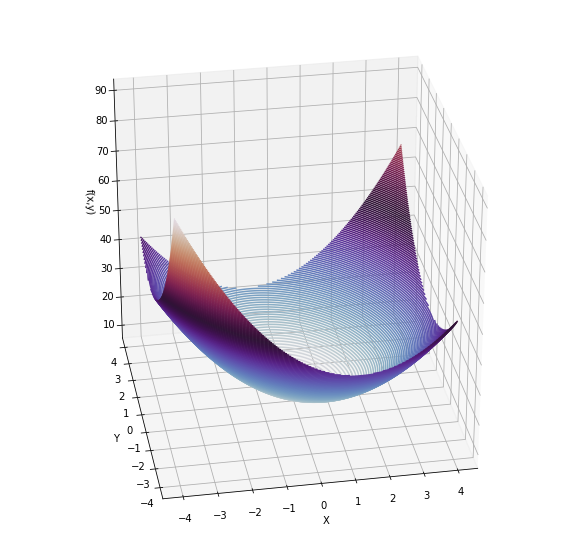

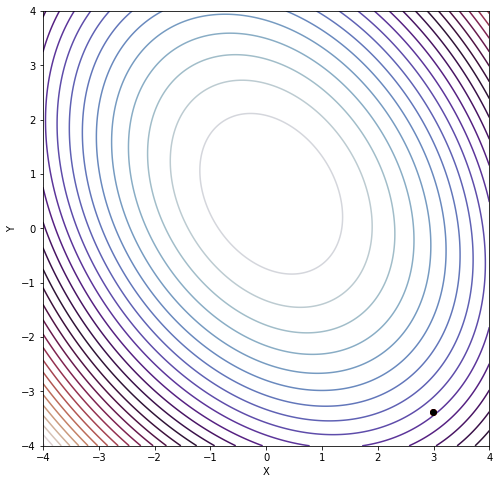

In [6]:
# here we plot the function and find a starting position for optimization

x_min, x_max, y_min, y_max = -4, 4, -4, 4
x0 = init(x_min, x_max, y_min, y_max)

get3Dplot(x_min, x_max, y_min, y_max, f1)
getContour(x_min, x_max, y_min, y_max, f1, [np.array(x0)], 3)

This function is bowl-shaped, with a single local optimum. How well does gradient descent do to find the global mimimum?

On the contour plot, you can see the randomly initialized position to test in our GD algorithm.

In [7]:
def gd(f, df,x0, N=1000):
    
    """
    An algorithm for gradient descent
    
    Parameters:
        f - function to be minimized (function)
        x0 - initial position (list)
        N - maximum number of iterations (int)
        
    Returns:
        converged - True if f is minimized else False (boolean)
        x_hist - steps taken in attempt to minimize f (array)
        f(x_now) - function value of minima (float)
    """
    
    x_now = x0
    x_prev = None
    converged = False
    x_hist = []
    x_hist.append(x_now)
    
    
    for i in range(N):
        
        df_now = df(x_now)
        
        if x_prev is None: # initialize step size for first iteration
            gamma = 0.001 
        else: # use eqn (?) to update gamma iteratively 
            df_prev = df(x_prev)
            gamma = np.dot(x_now-x_prev, df_now-df_prev) / np.linalg.norm(df_now-df_prev)**2
        x_next = x_now - gamma*df_now
        
        if abs(f(x_next)-f(x_now)) < 1e-4:
            converged = True
            break
        else:
            x_prev = x_now
            x_now = x_next
            x_hist.append(x_now)
            
    return converged, np.array(x_hist), f(x_now)


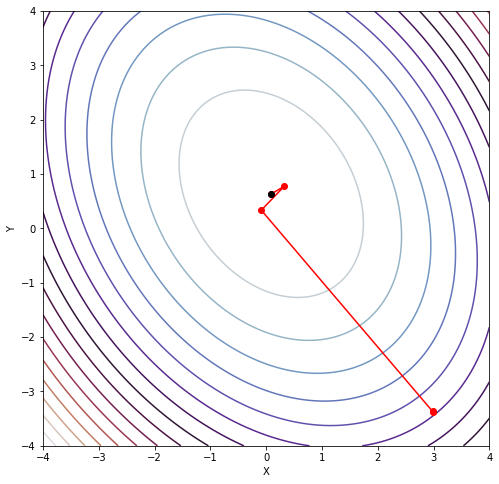

In [8]:
# here we run gradient descent and plot the results

converged, cache, f_min = gd(f1,df1, x0)
getContour(x_min, x_max, y_min, y_max, f1, cache, 5)

Gradient descent is obviously sufficient enough to use to find minimum for a function with one local optimum. How does it do for more complex structures?

### What about when there are two minimums in close proximity?

Gradient descent is good at minimizing a function with only one minimum, as we have seen. Furthermore, the function should ideally have a quadratic behavior around the minimum; higher-order functions where at least one variable is cubic or higher are more difficult to minimize using gradient descent. Furthermore, gradient descent typically fails when trying to find the minimum of a function with several minimums in close proximity (as we saw in lecture). Below we show an example of this. Depending on the starting position, GD may converge to either of the local minima, or it may converge to the saddle point in between. Thus, for global optimization GD is not suitable.

$$f(x,y) = \frac{1}{2}x^2 + \frac{1}{3}y^2 - \frac{1}{4}xy + 3e^{-x^2}\tag{2}$$ 


In [9]:
def f2(x):
    
    """
    Some function with two close local minima
    """
    
    return x[0]**2/2 + x[1]**2/3 - x[0]*x[1]/4 + 3* np.exp(-x[0]**2)

def df2(x):
    
    """
    Derivative of function two
    """
    
    return np.array([x[0] - x[1]/4 - 6*x[0]*np.exp(-x[0]**2), 2/3 * x[1] - 1/4 * x[0]])

    

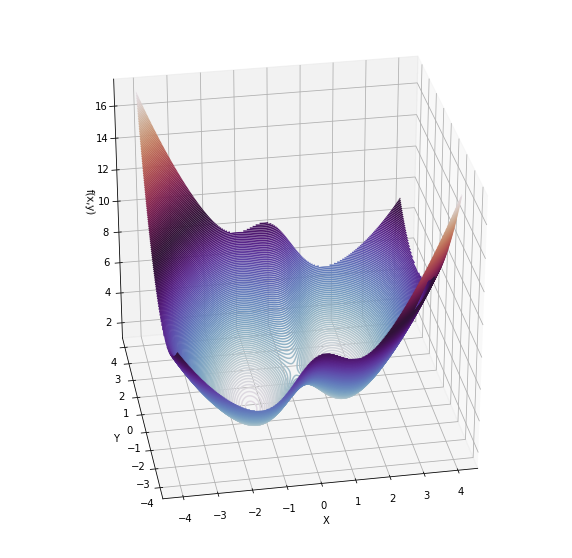

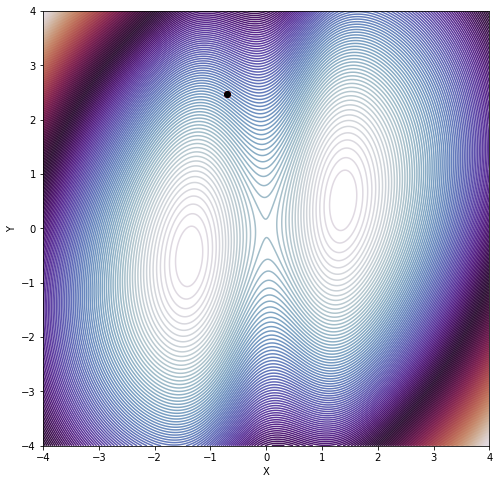

In [28]:
x_min, x_max, y_min, y_max = -4, 4, -4, 4
x0 = init(x_min, x_max, y_min, y_max)
cache = [] # a list for optimization steps
cache.append(x0)
get3Dplot(x_min, x_max, y_min, y_max, f2)
getContour(x_min, x_max, y_min, y_max, f2, cache, 0.1)

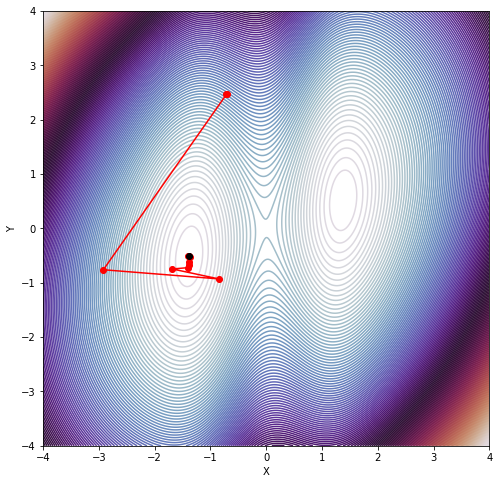

In [29]:
# here we run gradient descent and plot the results

converged, cache, f_min = gd(f2,df2, x0)
getContour(x_min, x_max, y_min, y_max, f2, cache,0.1)

Looks like the algorithm found only a single local minima, but we don't know if it is the global minima.

Lets see what happens if we run this about many times. This looks to be very sensetive to initial position, because there are 2 local minima and a saddle point. 

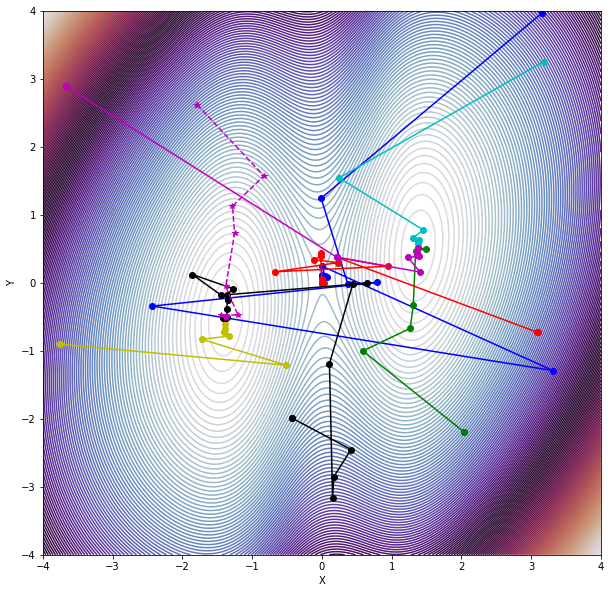

In [12]:
# here we run gradient descent for 8 different initial positions (corresponding to different matplotlib colors) 

c = ['bo-', 'go-', 'ro-', 'co-', 'mo-', 'yo-', 'ko-', 'm*--']

xs = np.linspace(x_min,x_max,500)
ys = np.linspace(y_min,y_max,500)
XS,YS = np.meshgrid(xs,ys)
ZS = f2([XS,YS])

fig = plt.figure(figsize=(10,10))
levels = np.arange(np.min(ZS), np.max(ZS), 0.1)
plt.contour(XS,YS,ZS, levels=levels,cmap = 'twilight')
plt.xlabel('X')
plt.ylabel('Y')

for color in c:
    x0 = init(x_min, x_max, y_min, y_max)
    converged, cache, f_min = gd(f2,df2, x0)
    cache = np.array(cache)
    contour = plt.plot(cache[:,0],cache[:,1],color)
plt.show()

As assumed, initial position matters immensely. This leads to the requirement that another optimization method is required to find the global minimum.

# Linear Conjugate Gradient 

The Conjugate Gradient Method is the most prominent iterative method for solving sparse systems of linear equations.

Effective for systems of the form $Ax=b$ where $x$ is an unknown vector, $b$ is a known vector, and $A$ is a known, square, symmetric, positive-definite matrix. 

Recall, from linear algebra, that $Ax=b$ written out fully is 

$$\left[\begin{array}
{rrr}
A_{11} & A_{12} & ... & A_{1n} \\
A_{21} & A_{22} &     & A_{2n} \\
\vdots &        & \ddots & \vdots \\
A_{n1} & A_{n2} & ... & A_{nn}
\end{array}\right]
\left[\begin{array}
{rrr}
x_1 \\
x_2 \\
\vdots \\
x_n
\end{array}\right] 
=
\left[\begin{array}
{rrr}
b_1 \\
b_2 \\
\vdots \\
b_n
\end{array}\right]
$$

Limitations to the linear conjugate gradient descent arise from the requirement of positive-definiteness ($x^TAx > 0$) + symmetry of A. This is expanded on later.


Linear conj. gradient descent starts out by defining some quadratic function of a vector with the following form:

$$f(x)=\frac{1}{2}x^TAx-b^Tx+c$$

We look for solutions x that satisfy the system of linear equations Ax=b. These values of x minimize the quadratic function f(x) since 

$$\nabla f(x) = Ax + B $$.

where A is a matrix, x and b are vectors, and c is a scalar constant.

## L-CG Algorithm

Below we discuss the algorithm behind minimizing these types of quadratic functions by solving a system of linear equations.

1. Generate initial starting point $(x_o, y_o)$

    - Use numpy's random number generator to generate starting position $(x_o, y_o)$.

2. Find initial search direction from: 

$$d_o = r_o = b - Ax_o$$

where b and A are our defined vector and matrix, $d_o$ is the *search direction*, and $r_o$ is the *residual*, or more importantly, the direction of descent. In the first iteration, we see that $d_o$ and $r_o$ are equal.

3. Determine the scalar constant *a* (this is essentially out step size)

    - We want to know how far along our search direction $d_i$ we need to go: this is determined by out step size *a*, and we can calculate it from our residuals and search directions from the current iteration.

$$a = \frac{r_i^Tr_i}{d_i^TAd_i}$$

        - Since our residuals tell us how far away we are from the optimum position along each search direction, calculating the step size from the residuals will ensure that our next step is of suitable size.

4. Find next point along the search direction:

$$x_{i+1} = x_i + a_id_i$$

5. Find next residual (direction of steepest descent/magnitude away from minimization)

$$r_{i+1} = r_i - a_iAd_i$$

6. Determine scalar constant $\beta$

$$\beta_{i+1} = \frac{r_{i+1}^Tr_{i+1}}{r_i^tr_i}$$

        - This constant is based off of the residuals and is used in finding the next search direction.

7. Find next search direction

$$d_{i+1} = r_{i+1} - \beta_{i+1}d_i$$

Thus, each successive search direction is calculated from the residuals and the previous search direction. We can say then, that the search directions are constructed by conjugation of the residuals. The residuals have the property that they are orthogonal to the previous search direction. That is, it can be shwon that $d_{i}^Tr_{j} = 0, i<j$. 

Finally, the algorithm iterates through steps 3-7 until the magnitude $||r_i||$ is less than the tolerance we specify. Since the residual $r_i$ represents the direction of steepest descent, the closer it is to zero, the closer we are to minimizing $f(x)$.

## Application of L-CG Algorithm

For example, for arbitrary choice of positive definite + symmetric matrix A, vector b, and some constant c:

$$ A =  \left[\begin{array}
{rrr}
4 & 1 \\
1 & 3
\end{array}\right],
b = \left[\begin{array}
{rrr}
1 \\
2
\end{array}\right],
c = 7.9
$$

we obtain the following function:

$$
\frac{1}{2}x^TAx-b^Tx+c = 
$$
$$
\frac{1}{2} \left[\begin{array} {rrr}x & y \\ \end{array}\right] A \left[\begin{array} {rrr}x \\ y \end{array}\right] - \left[\begin{array} {rrr}1 & 2 \\ \end{array}\right] \left[\begin{array} {rrr}x \\ y \end{array}\right] + 7.9 
$$

$$
= \frac{1}{2}(4x^2+3y^2+2xy) - (x+2y)+7.9
$$

$$
= 2x^2 + \frac{3}{2}y^2 + xy - x - 2y + 7.9
$$

and look for solutions x that satisfy the system of linear equations Ax=b.


In [13]:
def f(x, A, b, c):
    
    """
    Quadratic function to minimize
    """
    
    return float(0.5 * x.T * A * x - b.T * x + c)

def cg(x0,f,A,b,c):
    
    """
    Linear conjugate gradient descent algorithm 
    """
    
    converge = False
    count = 0
    cache = []
    cache.append(x0)
    max_iter = 100
    
    while converge == False :
        
        r0 = b - A*x0

        if count == 0:
            p0 = r0
        else:
            p0 = p

        alpha = (r0.T * r0)/(r0.T * A * p0)
        alpha = np.array(alpha)[0][0]

        x = x0 + alpha * p0
        r = r0 - alpha * A * p0

        beta = (r.T * r)/(r0.T * r0)
        beta = np.array(beta)[0][0]

        p = r + beta * p0
                        
        diff = np.linalg.norm(x-x0)
        
        cache.append(x)
        
        if np.linalg.norm(x-x0) < 1e-5:
            converge = True
            
        if count == max_iter:
            break
        

        x0 = x
        count +=1
    
    return cache

Again, we use the function derived above: $$f(x,y) = 2x^2 + \frac{3}{2}y^2 + xy - x - 2y + 7.9$$

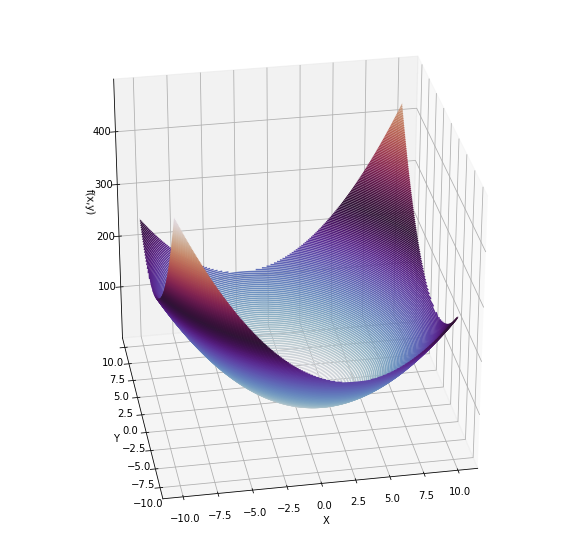

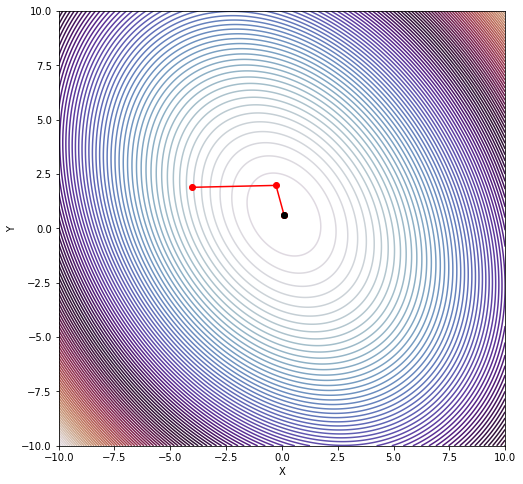

In [14]:
A = np.matrix([[4.0, 1.0], 
               [1.0, 3.0]])
b = np.matrix([[1.0], 
               [2.0]])  
c = 7.9

x_min, y_min = -10,-10
x_max, y_max = 10,10

x0 = np.array(init(x_min,x_max,y_min,y_max))
x0 = np.reshape(x0,(2,1))
cache = cg(x0,f1,A,b,c)

get3Dplot(x_min, x_max, y_min, y_max, f1)
getContour(x_min,x_max,y_min,y_max,f1,cache,5)

## L-CG Limitations
    1. The algorithm doesn't work for any arbitrary A. Again, A must be positive definite and symmetric. Some arbitrary matrix A may result as non-linear or non-positive indefinite matrix. 

Below we show the failue of linear conjugate gradient for A an assymetric matrix

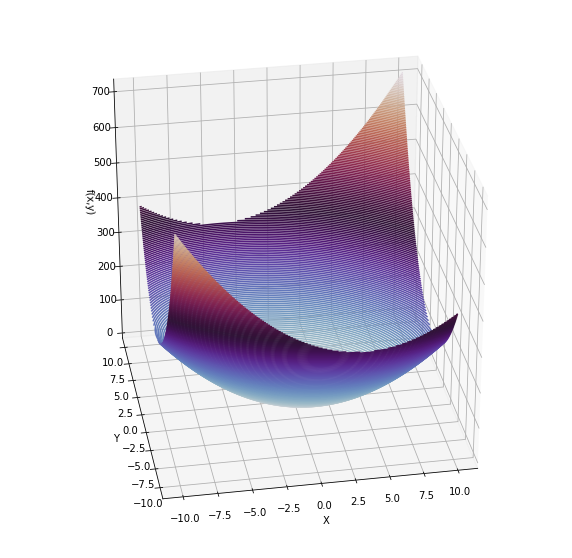

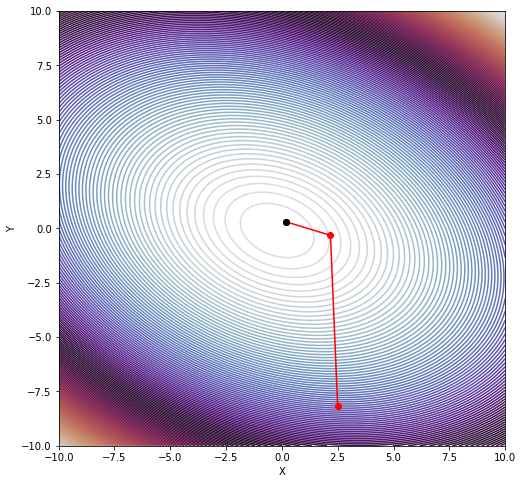

In [15]:
# assymetric A
A = np.matrix([[4.0, 1.0], 
               [1.0, 2.7]])
b = np.matrix([[1.0], 
               [1.0]])  
c = 7.9

def func1(x):
    return 2*x[0]**2 + 3/2 * x[0]*x[1] + 7/2 * x[1]**2 + x[0] + x[1]

x_min, y_min = -10,-10
x_max, y_max = 10,10

x0 = np.array(init(x_min,x_max,y_min,y_max))
x0 = np.reshape(x0,(2,1))
cache = cg(x0,func1,A,b,c)

get3Dplot(x_min, x_max, y_min, y_max, func1)
getContour(x_min,x_max,y_min,y_max,func1,cache,5)

The algorithm came awfully close to determining the global minima, but obviously didn't. Lets see if scipy can correctly find the minima with their CG minimization technique.

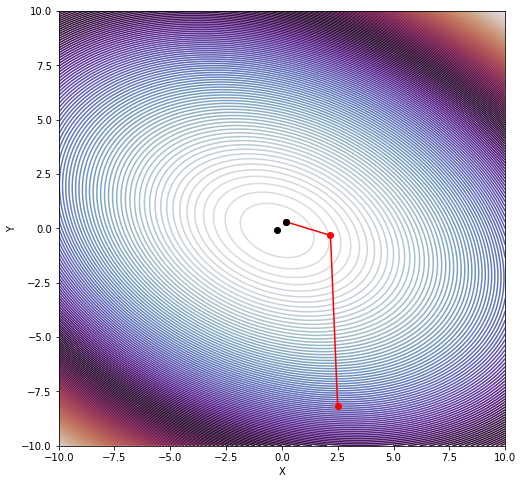

In [16]:
cache = np.array(cache)
getContour(x_min,x_max,y_min,y_max,func1,cache,5)

res = minimize(func1, x0, method='CG', tol=1e-3)
plt.plot(res.x[0],res.x[1],'ko')
plt.show()

Why is the scipy optimization method able to find the minima but not ours? Thats because our implementation is the Linear conjugate gradient descent method. 

### Brief introduction to nonlinear CG method

The conjugate gradient (CG) method implemented in the scipy minimize package actually uses the *nonlinear* conjugate gradient method. An extension of the linear CG method, the nonlinear CG method has a couple of key differences:

1) Line search

The line search in nonlinear CG now must produce a step length $\alpha_k$ that finds the minimum of a nonlinear function *f(x)* in the search direction $p_k$. Whereas in linear CG our line search was based off of the residuals and previous search directions, in the nonlinear CG method, line search is done using the derivatives of the objective function (similar to gradient descent). Furthermore, there is actually more than one choice in determining the step length through different line search formulas. For example, one popular method is the Fletcher-Reeves method, whose line search formula gives another parameter for determining $alpha_k$ is given below. $$B_{k+1}^{FR} = \frac{\nabla f_{k+1}^T * \nabla f_{k+1}}{\nabla f_k^T * \nabla f_k}$$

2) Replacing residual from linear CG with the gradient of the nonlinear objective function $f(x)$

As mentioned above, the line search used in nonlinear CG uses gradients in place of the residuals. After calculating the parameter in the above equation, one uses the following equation to determine the next search direction:
$$p_{k+1} = -\nabla f_{k+1} + B_{k+1}^FR * p_k$$


We saw that the linear CG method is restricted to quadratic functions, since the algorithm seeks to minimize the function by finding solutions to the gradient of the quadratic, i.e. to a system of linear equations $Ax=b$. One important advantage of nonlinear CG is its use for functions of higher-order.

# BFGS Method (Quasi-newton optimization)

Optimization method used to either find zeroes or local maxima and minima of functions, as an alternative to Newton's method.

In general, Newton and Quasi-Newton optimization techniques over some function $f(x)$ follow the same basic algorithm:

1. Ensure the $f(x)$ is twice differentiable
2. As with all optimization algorithms, choose some initial guess of the coordinates (x) that minimize $f(x)$
3. Calculate the search direction, $$ p_k = -H_k \nabla f(x_k)$$  where H_k is the Hessian of f_k.
4. Based on the search direction, calculate the new predicted coordinates $$x_{k+1} = x_k + \alpha_k \nabla f(x_k)$$
    - Before calculating $x_{k+1}$, several $\alpha_k$ (the step size) must satisfy the Wolfe Conditions
5. Update H_k (This step is what divides Newton's method from several Quasi-Newton methods)
6. Repeat until converge.

For Newton Optimization, the Hessian $H_k$ is calculated iteratively then stored for later use. In Quasi-Newton methods, the Hessian is approximated and iteratively disposed. 

Some Quasi-Newton Methods are BFGS, L-BFGS, Broyden, etc, which all differ mainly in the approximation in $H_k$.

### Wolfe Conditions: 
- Conditions that ensure the step size $\alpha_k$ will lead to convergence of optimization algorithm.
- a value of $\alpha_k$ that minimized some function f(x_k) is called a global minimizer. To efficiently locate $alpha_k$, a line search that satisfies two confitions must be implemented. 
1. Sufficient decrease condition: $f(x_k + \alpha_k p_k) \leq f(x_k)+c_1 \alpha_k \nabla f(x_k)p_k$
    - $\alpha_k \nabla f(x_k)p_k$ is the decrease in f predicted by the slope of f at x_k in the direction of p_k (must be < 0)
    - c1 in range (0,1)
    - Condition one is invoked to prevent the minimzation scheme from doing the following: 
    
    ![Image of WC1](https://pages.mtu.edu/~msgocken/ma5630spring2003/lectures/lines/lines/img15.gif)
    
    Iterations repeatedly go from one side of a valley to the other, always reducing f but never by much. The problem is that the reduction in each step is very little compared to the length of the steps--the steps are too long.
    
2. Curvature condition: $\nabla f(x_k + \alpha_k p_k) \geq c_2 \nabla f(x_k)p_k$
- $c_2$ must be within 0 and 1 and must be less than $c_1$
- The curvature condition guarantees that $\alpha_k$ is large enough that the line search doesn't take steps that are too small. 
    
In a nut shell, the above Wolfe-Conditions prevent the algorithm from continually reducing f without reducing it enough to obtain convergence.
    
The difficulty in implementing Quasi-Newton optimization algorithms arises from determining $\alpha_k$ iteratively. Below we show examples of a few algorithms using scipy. Further, code of out attempts is below.

In [30]:
def Hess(rho,s,y,H):
    I = np.eye(2)
    return (I - rho*s*y.T)*H*(I-rho*y*s.T) + rho*s*s.T

def wolfe(x, func, gradfunc, p, max_iter):
    
    """
    This line search finds the most suitable value for the step size based on two conditions:
    
    First, initialize the following values: 
    
    0 < c1 < c2 < 1, where c1 and c2 are constants
    alpha = 0
    step = 1
    beta = 1000
    i = 0
    
    step is our step size, beta and alpha will update our step size based on the wolfe conditions.
    
    Armijo condition - the reduction in f should be proportional to the step length and the directional derivative.
    Curvature condition - rules out too short of steps by evaluating the steepness of the slope (if not positive or negative enough, step will be too small)
    
        x is the most recent point and p is the most recent direction.
        gradfunc is the gradient of our function evaluated at the most recent point.
        
        Condition 1: Armijo (sufficient decrease)
        
        If f(x + step * p) > f(x) + c1 * step * gradfunc(x).T * p:
            set beta = step
            set step = 0.5*(alpha + beta)
            
        Condition 2: Curvature
        
        else if gradfunc(x + step*p).T * p < c2 * gradfunc(x).T * p:
            set alpha = step
            
            if beta > 100:
                set step = 2*alpha
            otherwise,
                set step = 0.5*(alpha + beta)
            
        else:
            break
        
    Continue iterating until a sufficient step size is produced, and return that step size.
                   
    """
    
    c1 = 1e-4
    c2 = 0.90
    alpha = 0
    step = 1
    beta = 1000
    i = 0

    while i <= max_iter:
        wcL = func(x+step*p)
        wcR = func(x) + c1*step* np.dot(gradfunc(x).T,p)
                
        if wcL > wcR:
            beta = step
            step = 0.5*(alpha + beta)
        
        elif np.dot(gradfunc(x+step*p).T,p) < np.dot(c2*gradfunc(x).T,p):
            alpha = step
            if beta > 100:
                step = 2*alpha
            else:
                step = 0.5*(alpha + beta)
        else:
            break
        
        i += 1
        stop_val = x + step*p
        stop_iter = i
        minima = func(stop_val)
    
    return step

def _line_search_wolfe12(f, fprime, x0, p, g0, old_fval, old_old_fval,
                         **kwargs):
    
    """
    This was obtained from scipy and simplified

    Same as line_search_wolfe1, but fall back to line_search_wolfe2 if
    suitable step length is not found, and raise an exception if a
    suitable step length is not found.
    
    Raises
    ------
    _LineSearchError
        If no suitable step size is found
    """
   
    # performs the first line search, returns 
    # the following: alpha, f_count, g_count, fval, old_fval, gval, 
    # most important return is alpha
    
    extra_condition = kwargs.pop('extra_condition', None)
    
    ret = line_search_wolfe1(f, fprime, x0, p, g0,
                             old_fval, old_old_fval,
                             **kwargs)

    if ret[0] is not None:
        xp1 = x0 + ret[0] * p 


    if ret[0] is None:
        # line search failed: try different one.
        kwargs2 = {}
        for key in ('c1', 'c2', 'amax'):
            if key in kwargs:
                kwargs2[key] = kwargs[key]
        ret = line_search_wolfe2(f, fprime, x0, p, g0,
                                 old_fval, old_old_fval,
                                 extra_condition=extra_condition,
                                 **kwargs2)

    if ret[0] is None:
        print('Line search failed')

    return ret
    
def BFGS(func, gradfunc, x0, gtol, ls, alpha):
    
    # gradient at x0
    g0 = gradfunc(x0)

    # initialize hessian
    I = np.eye(2)
    H = I

    gnorm = np.linalg.norm(g0)

    # Sets the initial step guess to dx ~ 1
    old_fval = func(x0)
    old_old_fval = old_fval + gnorm / 2 # (required for scipy linesearch) WHAT IS THIS FOR

    k = 0
    maxiter = 100

    cache = [x0]
        
    # gnrom > gtol: at the minima, the slope should be ~ 0
    # k < maxiter: some threshold to avoid too many iters

    while (gnorm > gtol) and (k < maxiter):
        
        p = -np.dot(H, g0) # search direction

        if ls == 'scipy':
            # apply the wolf conditions, should return some step size that satisfies WC
            alpha, fc, gc, old_fval, old_old_fval, gf = \
                     _line_search_wolfe12(func, gradfunc, x0, p, g0,
                                          old_fval, old_old_fval, amin=1e-100, amax=1e100)

            # fail if the wolf conditions are not met
            if alpha == None:
                print('wolf condition not met')
                break


        elif ls == 'ours':
            alpha = wolfe(x0,func,gradfunc,p,10)
            gf = None

        # update point
        x = x0 + alpha * p
        
        # scipy returns the gradient, ours doesnt
        if gf is None:
            gf = gradfunc(x)

        # append point to cache
        cache.append(x)
        
        # for updating hessian
        s = x - x0
        y = gf - g0
        rho = 1.0 / (np.dot(y, s))
        
        # updates to hessian ( put this in a function)
        A1 = I - s[:, np.newaxis] * y[np.newaxis, :] * rho
        A2 = I - y[:, np.newaxis] * s[np.newaxis, :] * rho
        H = np.dot(A1, np.dot(H, A2)) + (rho * s[:, np.newaxis] *
                                                 s[np.newaxis, :])
        
        # update tolerance condition
        gnorm = np.linalg.norm(g0)
        
        # updates for next iteration
        x0 = x
        g0 = gf
        k += 1
        
    return cache

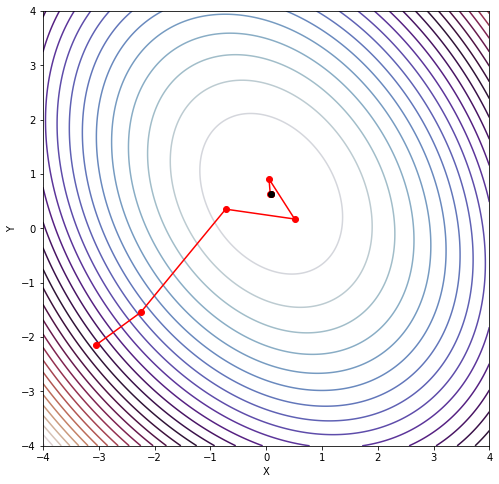

In [31]:
# the infinities arise from rho, scipy fixes this by setting rho to a big number when infinity arises, we don't do that here
# results still converge

x0 = np.array(init(x_min, x_max, y_min, y_max)).flatten()
cache = BFGS(f1, df1, x0, 1e-3, 'scipy', 1)
getContour(x_min, x_max, y_min, y_max, f1, cache, 3)

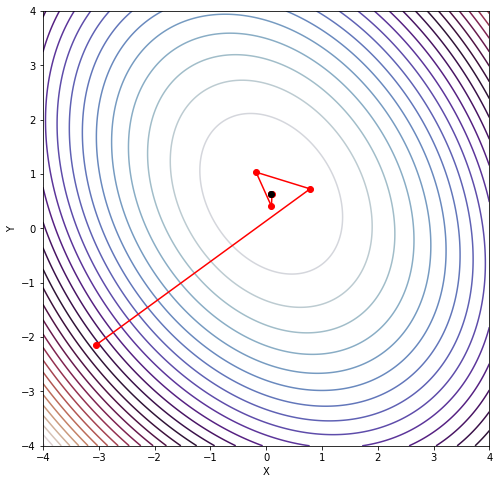

In [32]:
cache = BFGS(f1,df1, x0, 1e-3, 'ours', 1)
getContour(x_min, x_max, y_min, y_max, f1, cache, 3)

##### Notice that the minimization path is very different for  different wolfe condition schemes

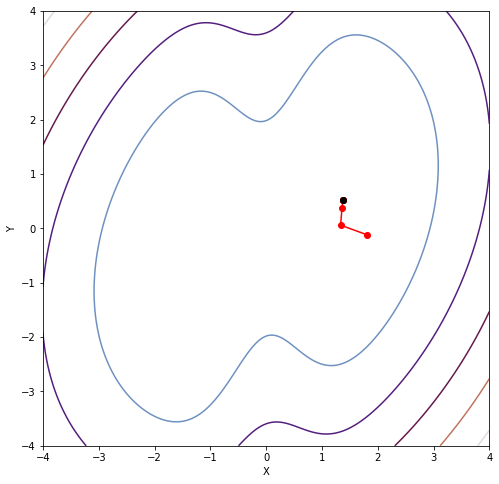

In [33]:
x0 = np.array(init(x_min, x_max, y_min, y_max)).flatten()
cache = BFGS(f2,df2, x0, 1e-3, 'scipy', 1)
getContour(x_min, x_max, y_min, y_max, f2, cache, 3)

Whether we use gradient descent or some Quasi-Newton optimization method, functions with two local minima need some stronger optimization algorithms like basin hopping . 

### Finally, we compare each models ability to minimize function one if the initial point is started somewhere far away.

In [40]:
x0 = [-6.5,9.8]

In [41]:
converged, cacheGD, f_min = gd(f1,df1, x0)
%timeit gd(f1,df1, x0)
print('number of steps', len(cacheGD))

137 µs ± 4.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
number of steps 6


In [42]:
A = np.matrix([[4.0, 1.0], 
               [1.0, 3.0]])
b = np.matrix([[1.0], 
               [2.0]])  
c = 7.9

x0 = np.array(x0)
x0 = np.reshape(x0,(2,1))
cacheCG = np.array(cg(x0,f1,A,b,c))
%timeit cg(x0,f1,A,b,c)
print('number of steps', len(cacheCG))

283 µs ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
number of steps 4


In [43]:
x0 = x0.flatten()
cacheBFGS1 = np.array(BFGS(f1, df1, x0, 1e-3, 'ours', 1))
%timeit BFGS(f1, df1, x0, 1e-3, 'ours', 1)
print('number of steps', len(cacheBFGS1))

434 µs ± 5.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
number of steps 7


In [44]:
x0 = x0.flatten()
cacheBFGS2 = np.array(BFGS(f1, df1, x0, 1e-3, 'scipy', 1))
%timeit BFGS(f1, df1, x0, 1e-3, 'scipy', 1)
print('number of steps', len(cacheBFGS2))

/Users/sayred1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:182: RuntimeWarning: divide by zero encountered in double_scalars
/Users/sayred1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in multiply
/Users/sayred1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in multiply
/Users/sayred1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in multiply


440 µs ± 8.27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
number of steps 7


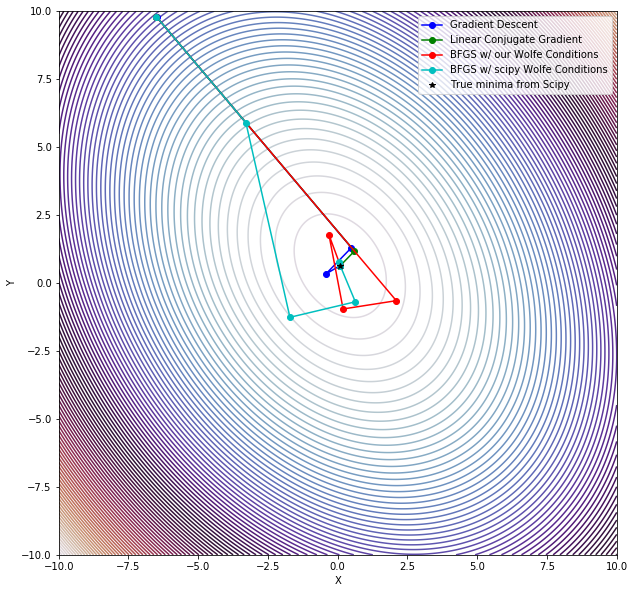

In [47]:
xs = np.linspace(-10,10,500)
ys = np.linspace(-10,10,500)
XS,YS = np.meshgrid(xs,ys)
ZS = f1([XS,YS])

fig = plt.figure(figsize=(10,10))
levels = np.arange(np.min(ZS), np.max(ZS), 5)
plt.contour(XS,YS,ZS, levels=levels,cmap = 'twilight')
plt.xlabel('X')
plt.ylabel('Y')

plt.plot(cacheGD[:,0],cacheGD[:,1],'bo-', label = 'Gradient Descent')
plt.plot(cacheCG[:,0],cacheCG[:,1],'go-', label = 'Linear Conjugate Gradient')
plt.plot(cacheBFGS1[:,0],cacheBFGS1[:,1],'ro-', label = 'BFGS w/ our Wolfe Conditions')
plt.plot(cacheBFGS2[:,0],cacheBFGS2[:,1],'co-', label = 'BFGS w/ scipy Wolfe Conditions')
plt.plot(xf1[0],xf1[1],'k*', label = 'True minima from Scipy')
plt.legend(loc='upper right')
plt.show()

## Summary 

1. Each algortithm found the global minima of function 1. Of all methods, conjugate gradient descent did it in the least amount of steps. 
2. Out of each algorithm, Gradient Descent took the least amount of time, Conj. grad. the second, and the BFGS methods the longest. The latter took the longest due to the checking of wolfe conditions each iterations, cong. grad took second longest because of the matrix operations, and gradient descent was the fastest due to simplicity (calculate gradient at some point, update, rinse and repeat until convergence).
3. To solve a function like function 2 (a function with more than one local minima), the optimization methods here are note sufficient.